# CSC-52081-EP Lab5: Reinforcement Learning - TD Learning, QLearning and SARSA

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/refs/heads/main/assets/logo.jpg" style="float: left; width: 15%" />

[CSC-52081-EP-2025](https://moodle.polytechnique.fr/course/view.php?id=19336) Lab session #5

2019-2025 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-csc-52081-ep-2025-students/blob/main/lab5_rl2_tdlearning_qlearning_sarsa.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-csc-52081-ep-2025-students/main?filepath=lab5_rl2_tdlearning_qlearning_sarsa.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-csc-52081-ep-2025-students/blob/main/lab5_rl2_tdlearning_qlearning_sarsa.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/raw/main/lab5_rl2_tdlearning_qlearning_sarsa.ipynb)

## Introduction

The purpose of this lab is to introduce some classic concepts used
in reinforcement learning: *Temporal Difference Learning* (*TD Learning*), *QLearning* and *SARSA*.

As for previous lab, you can either:
- open, edit and execute the notebook in *Google Colab* following this link: https://colab.research.google.com/github/jeremiedecock/polytechnique-csc-52081-ep-2025-students/blob/main/lab5_rl2_tdlearning_qlearning_sarsa.ipynb ; this is the **recommended** choice as you have nothing to install on your computer
- open, edit and execute the notebook in *MyBinder* (if for any reason the Google Colab solution doesn't work): https://mybinder.org/v2/gh/jeremiedecock/polytechnique-csc-52081-ep-2025-students/main?filepath=lab5_rl2_tdlearning_qlearning_sarsa.ipynb
- download, edit and execute the notebook on your computer if Python3 and JypyterLab are already installed: https://github.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/raw/main/lab5_rl2_tdlearning_qlearning_sarsa.ipynb

If you work with Google Colab or MyBinder, **remember to save or download your work regularly or you may lose it!**

## Lab Submission

Please submit your completed notebook in [Moodle : "Lab 5 - Submission"](https://moodle.polytechnique.fr/course/section.php?id=66533).

### Submission Guidelines

1. **File Naming:** Rename your notebook as follows: **`firstname_lastname-05.ipynb`** where `firstname` and `lastname` match your email address. *Example: `jesse_read-05.ipynb`*
2. **Clear Output Cells:** To reduce file size (**must be under 500 KB**), clear all output cells before submitting. This includes rendered images, videos, plots, and dataframes...
   - **JupyterLab:**
     - Click **"Kernel" → "Restart Kernel and Clear Outputs of All Cells..."**
     - Then go to **"File" → "Save Notebook As..."**
   - **Google Colab:**
     - Click **"Edit" → "Clear all outputs"**
     - Then go to **"File" → "Download" → "Download.ipynb"**
   - **VSCode:**
     - Click **"Clear All Outputs"**
     - Then **save your file**
3. **Upload Your File:** Only **`.ipynb`** files are accepted.

**Note:** Bonus parts (if any) are optional, as their name suggests.


## Python requirements

This notebook requires the following Python libraries: *Gymnasium*, NumPy, Pandas, Seaborn.

### If you use Google Colab

Execute the next cell to install required libraries.

In [96]:
colab_requirements = ["gymnasium[other]", "ipywidgets", "numpy", "pandas", "seaborn", "tqdm"]  # "other" is required in gymnasium to use "gym.wrappers.RecordVideo"

import sys
import subprocess


def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())


if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

### If you use MyBinder

Required libraries are already installed, you have nothing to do.

### If you have downloaded the notebook on your computer and execute it in your own Python environment

Uncomment and execute the following cell to install required packages in your local environment (remove only the `#` not the `!`).

In [97]:
!pip install gymnasium[other] ipywidgets numpy pandas seaborn tqdm

Defaulting to user installation because normal site-packages is not writeable


## Import required libraries

In [98]:
import gymnasium as gym
import math
import numpy as np
import pandas as pd
from pathlib import Path

from typing import cast, List, Optional, Sequence, Tuple, Union

In [99]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm

In [100]:
from IPython.display import Video

In [101]:
sns.set_context("talk")

In [102]:
# matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

## Setup the FrozenLake toy problem with Gymnasium

For the purpose of focusing on the algorithms, we will use standard environments provided
by the Gymnasium framework. Especially, as in Lab 4, we will try to solve the FrozenLake-v1
problem (https://gymnasium.farama.org/environments/toy_text/frozen_lake/).
As a reminder, this environment is described [here](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

The action indices are outlined below:

| Action Index | Action     |
|--------------|------------|
| 0            | Move Left  |
| 1            | Move Down  |
| 2            | Move Right |
| 3            | Move Up    |

The following dictionary may be used to understand actions:

In [103]:
action_labels = {0: "Move Left", 1: "Move Down", 2: "Move Right", 3: "Move Up"}

**Notice**: this environment is *fully observable*, thus here the terms (environment) *state* and (agent) *observation* are equivalent.
This is not always the case for example in poker, the agent doesn't know the opponent's cards.

### Display functions

The next cells contain three functions that can be used to display Q-tables, states and (greedy) policies in the FrozenLake environment.

In [104]:
# Display the Q-table as a set of heatmaps, one for each action
def display_qtable(
    q_array: np.ndarray,
    title: str = "",
    figsize: Tuple[int, int] = (4, 4),
    annot: bool = True,
    fmt: str = "0.1f",
    linewidths: float = 0.5,
    square: bool = True,
    cbar: bool = False,
    cmap: str = "Reds",
    ticklabels: bool = False,
) -> None:
    """
    Display a Q-table as a set of heatmaps, one for each action.

    For the frozen lake environment, there are 16 states and 4 actions thus this function will display 4 heatmaps, one for each action.
    Each heatmap will display the Q-values for each state when performing the action indexed by the heatmap.

    Parameters
    ----------
    q_array : np.ndarray
        The Q-table to display. A 2D numpy array of 16x4 elements.
        Each row corresponds to a state, and each column corresponds to an action.
        In the frozen lake environment, there are 16 states and 4 actions thus the Q-table has a shape of (16, 4).
        For instance, q_array[0, 3] is the Q-value (estimation of the expected reward) for performing action 3 ("move up") in state 0 (the top left square).
    title : str, optional
        The title of the plot. Default is an empty string.
    figsize : tuple, optional
        The size of the figure (in inches), by default (4, 4)
    annot : bool, optional
        If True, write the data value in each cell, by default True
    fmt : str, optional
        The string formatting code to use when adding annotations, by default "0.1f" that will display a single decimal
    linewidths : float, optional
        The width of the lines that will divide each cell, by default .5
    square : bool, optional
        Whether to set the Axes aspect to "equal" so each cell is square-shaped, by default True
    cbar : bool, optional
        Whether to draw a colorbar, by default False
    cmap : str, optional
        The mapping from data values to color space, by default "Reds".
    heatmap : bool, optional
        If True, display the data as a heatmap. Default is True.
    ticklabels : bool, optional
        If True, display the tick labels. Default is False.

    Returns
    -------
    None
    """
    # Get the number of actions from the shape of the Q-table
    num_actions = q_array.shape[1]

    # Adjust the figure size (in inches) based on the number of actions
    global_figsize = list(figsize)
    global_figsize[0] *= num_actions

    # Create a subplot for each action
    fig, ax_list = plt.subplots(ncols=num_actions, figsize=global_figsize)

    # For each action, display the Q-values for all states as a heatmap
    for action_index in range(num_actions):
        ax = ax_list[action_index]

        # Retrieve the Q-values for each state when performing the action indexed by "action_index".
        # This forms a 1D array, state_vec, where state_vec[i] = Q(i, action_index).
        state_vec = q_array[:, action_index]

        # Display the Q-values for each state when performing the action indexed by "action_index"
        # i.e. display Q(., action_index)
        display_state(
            state_vec,
            title=r"$Q(\cdot,a_{})$".format(action_index),
            # title=r"$Q(\cdot,a_{})$ {}".format(action_index, action_labels[action_index]),
            figsize=figsize,
            annot=annot,
            fmt=fmt,
            linewidths=linewidths,
            square=square,
            cbar=cbar,
            cmap=cmap,
            ticklabels=ticklabels,
            ax=ax,
        )

    # Set the title for the entire figure
    plt.suptitle(title)
    # Display the figure
    plt.show()

In [105]:
def display_state(
    state_seq: Union[List[int], List[float], np.ndarray],
    title: str = "",
    figsize: Tuple[int, int] = (5, 5),
    annot: bool = True,
    fmt: str = "0.1f",
    linewidths: float = 0.5,
    square: bool = True,
    cbar: bool = False,
    cmap: str = "Reds",
    ticklabels: bool = False,
    ax: Optional[matplotlib.axes.Axes] = None,
) -> Union[matplotlib.axes.Axes, None]:
    """
    Display the expected values of all states as a heatmap.

    Parameters
    ----------
    state_seq : list of int, list of float or 1D numpy array of 16 elements
        The sequence of expected values to display. This can be a list, a 1D array, etc.
        Each element is the estimation of the expected value of the corresponding state.
        For example, state_seq[0] is the estimation of the expected value of the first state.
        There are 16 elements in this sequence for the frozenlake environment, i.e., one per state of the environment.
    title : str, optional
        The title of the plot, by default None
    figsize : tuple, optional
        The size of the figure (in inches), by default (5, 5)
    annot : bool, optional
        If True, write the data value in each cell, by default True
    fmt : str, optional
        The string formatting code to use when adding annotations, by default "0.1f"
    linewidths : float, optional
        The width of the lines that will divide each cell, by default .5
    square : bool, optional
        Whether to set the Axes aspect to "equal" so each cell is square-shaped, by default True
    cbar : bool, optional
        Whether to draw a colorbar, by default False
    cmap : str, optional
        The mapping from data values to color space, by default "Reds".
    ticklabels : bool, optional
        If True, display the tick labels. Default is False.
    ax : matplotlib.axes.Axes, optional
        The axes object to draw the heatmap on, by default None

    Returns
    -------
    matplotlib.axes.Axes, optional
        The axes object with the heatmap if one was provided, otherwise None.
    """
    # Calculate the size of the state array
    size = int(math.sqrt(len(state_seq)))

    # Convert the state sequence to a numpy array (if it isn't already one)
    state_array = np.array(state_seq)

    # Reshape the state array into a square matrix
    # (we assume here that the original frozen lake environment is used,
    # thus the state space can be visualized as a square grid)
    state_array = state_array.reshape(size, size)

    # If no axes object is provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Create a heatmap of the state array on the axes
    ax = sns.heatmap(
        state_array,
        annot=annot,
        fmt=fmt,
        linewidths=linewidths,
        square=square,
        cbar=cbar,
        cmap=cmap,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
        ax=ax,
    )

    # If a title is provided, set the title of the plot
    if title != "":
        if ax is None:
            plt.title(title)
        else:
            ax.set_title(title)

    # If no axes object was provided, display the plot
    # Otherwise, return the axes object with the heatmap
    if ax is None:
        plt.show()
        return None
    else:
        return ax

In [106]:
def display_policy(policy: List[int], environment: gym.Env) -> None:
    """
    Display the policy as a heatmap.

    Parameters
    ----------
    policy : list of int
        The policy to be displayed. Each integer represents an action to be taken in a state.

    Returns
    -------
    None
    """
    # Create a list of actions with their corresponding labels
    actions_src = [
        f"{action}={action_labels[action].replace('Move ', '')}" for action in range(environment.action_space.n)
    ]

    # Create a title for the heatmap using the actions and their labels
    title = f"Policy ({', '.join(actions_src)})"

    # Use the display_state function to create a heatmap of the policy
    # The fmt parameter is set to "d" to display integers, cbar is set to False to not display a colorbar,
    # and cmap is set to "Reds" to use the Reds color map
    display_state(policy, title=title, fmt="d", cbar=False, cmap="Reds")

## Exercise 1: TD Learning

**Notice**: Here we assume that the reward only depends on the state: $r(\boldsymbol{s}) \equiv \mathcal{r}(\boldsymbol{s}, \boldsymbol{a}, \boldsymbol{s}')$.

**Notice**:
-  $\mathcal{S}$ is the set of all nonterminal states
-  $\mathcal{S^F}$ is the set of all terminal states
-  $\mathcal{S^+}$ is the set of all states, includint the terminal states

In Lab4, we explored Dynamic Programming methods that can be used to solve Markov Decision Process (MDP) when the environment is perfectly known to the agent, i.e., in cases where the agent knows the transition and reward functions in advance. However, this is a strong assumption, as in most practical problems, these functions are not known beforehand. In this lab, we will learn how to create agents that can solve Markov Decision Problems without prior knowledge of the environment. These agents learn the dynamics of their environment by exploring it and use this knowledge to find an optimal policy.

We will start with the *TD Learning* (*Temporal Difference Learning*) algorithm, which can be used to **evaluate** any **given policy** (i.e. compute the *value function* of the environment following the given policy).
Variants of TD Learning can also be adapted for optimal control, such as in applications like [TD-Gammon](https://en.wikipedia.org/wiki/TD-Gammon).
Exercises 2 and 3 also reuse the main concepts of TD Learning to calculate an optimal policy.

The algorithm is outlined below.

---

### The TD Learning algorithm

<b>Input</b>:<br>
	$\quad\quad$ the policy $\pi$ to be evaluated<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br><br>

Initialize $V(\boldsymbol{s}) ~~~ \forall \boldsymbol{s} \in \mathcal{S^+}$, arbitrarily except that V(terminal)=0<br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\boldsymbol{s} \leftarrow \text{env.reset}() \quad\quad\quad\quad\quad\quad$ (initialize $s$)<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\boldsymbol{a} \leftarrow \pi(\boldsymbol{s})$<br>
		$\quad\quad$ $\boldsymbol{s}', r \leftarrow \text{env.step}(\boldsymbol{a}) \quad\quad\quad\quad$ (take action $a$, observe $r$ and $s'$)<br>
		$\quad\quad$ $V(\boldsymbol{s}) \leftarrow V(\boldsymbol{s}) + \alpha \left[ \underbrace{\overbrace{r + \gamma ~ V(\boldsymbol{s}')}^{\text{Target for } V(\boldsymbol{s})} ~ - ~ V(\boldsymbol{s})}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $\boldsymbol{s} \leftarrow \boldsymbol{s}'$<br>
	$\quad$ <b>UNTIL</b> $\boldsymbol{s}$ is final

**Notice**: in the following cell, `policy` is a list of actions (one per state c.f. two cells bellow).

### Task 1: Implement the TD Learning algorithm

In [107]:
DISPLAY_EVERY_N_EPISODES = 50

def td_learning(
    policy: Sequence[float],
    environment: gym.Env,
    alpha: float = 0.1,
    alpha_factor: float = 0.995,
    gamma: float = 0.95,
    num_episodes: int = 1000,
    display: bool = False,
) -> Tuple[np.ndarray, List[np.ndarray], List[float]]:
    """
    Perform Temporal Difference learning on a given policy and environment.

    Parameters
    ----------
    policy : Sequence[float]
        The policy to be learned, represented as a sequence mapping states (the index of the sequence) to actions (the value of the sequence for this index).
        For example, policy[0] is the action to take in state 0.
    environment : gym.Env
        The environment in which the agent operates.
    alpha : float, optional
        The learning rate, between 0 and 1. By default 0.1
    alpha_factor : float, optional
        The factor by which the learning rate alpha decreases each episode, by default 0.995
    gamma : float, optional
        The discount factor, between 0 and 1. By default 0.95
    num_episodes : int, optional
        The number of episodes to run, by default 1000
    display : bool, optional
        Whether to display the value function (every DISPLAY_EVERY_N_EPISODES episodes), by default False

    Returns
    -------
    np.ndarray
        The learned value function. This is a 1D ndarray with a shape of (16,) as there are 16 states in the frozenlake environment.
    """
    # Initialize the history of the value function and the learning rate
    v_array_history = []
    alpha_history = []

    observation_space = cast(gym.spaces.Discrete, environment.observation_space)

    # Get the number of states in the environment
    num_states = observation_space.n

    # Initialize the value function to zeros
    v_array = np.zeros(num_states)

    # Loop over the episodes
    for episode_index in tqdm(range(1, num_episodes)):
        # Display the value function every DISPLAY_EVERY_N_EPISODES episodes if display is True
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            display_state(
                v_array,
                title=f"Value function (ep. {episode_index})",
                cbar=True,
                cmap="Reds",
            )

        # Save the current value function and learning rate
        v_array_history.append(v_array.copy())
        alpha_history.append(alpha)

        # Decrease the learning rate if alpha_factor is not None
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        # TODO...
        # Initialize the state
        state, _ = environment.reset()

        done = False
        while not done:
            # Select action based on the policy
            action = policy[state]

            # Take the action and observe the next state and reward
            next_state, reward, done, _, _ = environment.step(action)

            # Update the value function using the TD learning update rule
            td_error = reward + gamma * v_array[next_state] - v_array[state]
            v_array[state] += alpha * td_error

            # Move to the next state
            state = next_state

    # Return the learned value function
    return v_array, v_array_history, alpha_history

**Note**: In the following cell, the `display` argument can be set to `True` to see the evolution of the value function `v_array` over iterations.

In [108]:
# Define the policy to evaluate
policy = [
    0, 3, 3, 3,
    0, 0, 0, 0,
    3, 1, 0, 0,
    0, 2, 1, 0
]

# Create the environment and set the maximum number of steps per episode
environment = gym.make("FrozenLake-v1", max_episode_steps=1000)

# Apply Temporal Difference (TD) Learning to calculate the value function for the policy defined earlier, within the context of the FrozenLake environment.
v_array_ex1, v_array_history_ex1, alpha_history_ex1 = td_learning(policy, environment, display=False)

environment.close()

  0%|          | 0/999 [00:00<?, ?it/s]

{0: 'Move Left', 1: 'Move Down', 2: 'Move Right', 3: 'Move Up'}

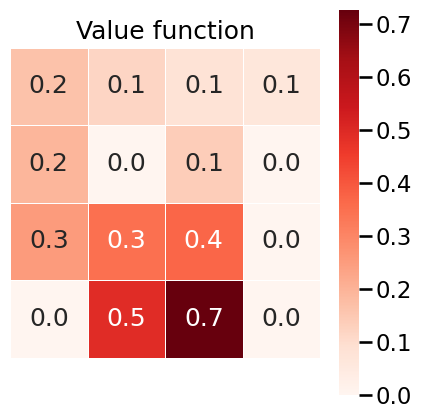

In [109]:
# Display the learned value function
display_state(v_array_ex1, title="Value function", cbar=True, cmap="Reds");
action_labels

#### Question 1

Copy and paste the output of the following cell into the first question of the [Lab 5 - Evaluation](https://moodle.polytechnique.fr/course/section.php?id=66533) in Moodle:  
*"What is the expected value of the 9th state in the FrozenLake environment for the given policy π using the default parameters?"*

In [110]:
answers_list = []
NUM_RUNS = 10
for episode_index in tqdm(range(1, NUM_RUNS + 1)):
    v_array_ex1, v_array_history_ex1, alpha_history_ex1 = td_learning(policy, environment, display=False)
    answers_list.append(v_array_ex1[8].item())

reward_df = pd.DataFrame(answers_list)
print(f"{np.average(reward_df).item():.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

0.27


### Display the evolution of the value function over iterations

In [111]:
# Print the evolution of the value function during the learning process
df_v_hist_ex1 = pd.DataFrame(v_array_history_ex1)
df_v_hist_ex1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.099500,0.0
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000793,0.000000,0.0,0.0,0.016074,0.180569,0.0
3,0.000017,0.00000,0.000000,0.000000,0.000145,0.0,0.000000,0.0,0.000920,0.006616,0.028215,0.0,0.0,0.033279,0.222097,0.0
4,0.000029,0.00000,0.000000,0.000000,0.000319,0.0,0.002217,0.0,0.001963,0.015595,0.039167,0.0,0.0,0.053721,0.269427,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.180761,0.10856,0.068476,0.048093,0.208755,0.0,0.131135,0.0,0.270333,0.372173,0.377525,0.0,0.0,0.519926,0.740966,0.0
995,0.180773,0.10856,0.068476,0.048093,0.208787,0.0,0.131045,0.0,0.270390,0.372330,0.377352,0.0,0.0,0.519682,0.740966,0.0
996,0.180772,0.10856,0.068476,0.048093,0.208828,0.0,0.131045,0.0,0.270340,0.372494,0.377352,0.0,0.0,0.519677,0.741142,0.0
997,0.180789,0.10856,0.068476,0.048093,0.208876,0.0,0.131045,0.0,0.270352,0.372241,0.377557,0.0,0.0,0.519677,0.741317,0.0


Evolution of `v_array_ex1` (the estimated expected value of each state) over iterations (one curve per state):

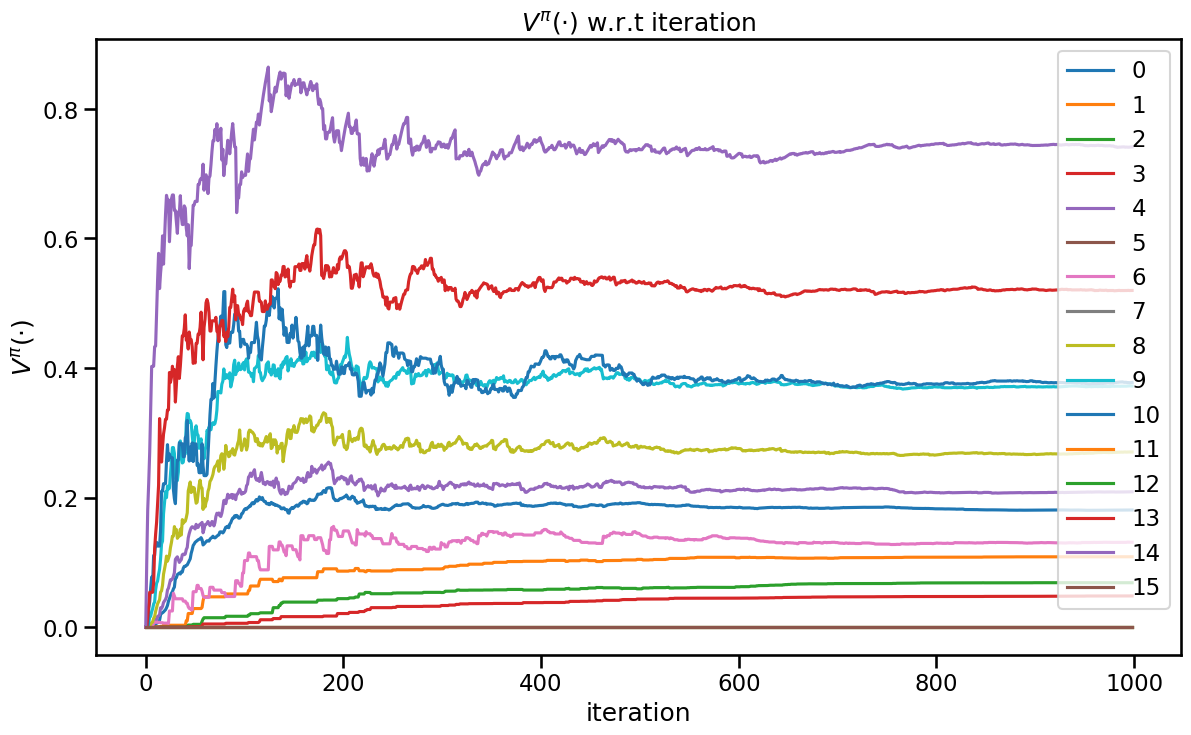

In [112]:
# Show the evolution of the estimated expected value for each state during the learning process
df_v_hist_ex1.plot(figsize=(14, 8))
plt.title(r"$V^{\pi}(\cdot)$ w.r.t iteration")
plt.ylabel(r"$V^{\pi}(\cdot)$")
plt.xlabel("iteration")
plt.legend(loc="upper right");

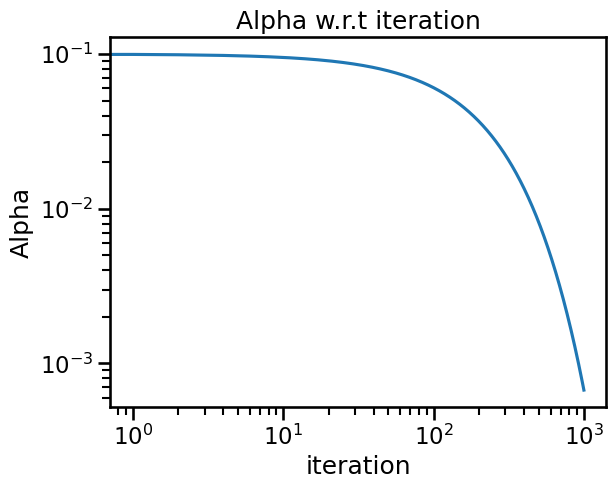

In [113]:
# Show the evolution of the alpha parameter during the learning process
plt.loglog(alpha_history_ex1)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration");

### Task 2: The learning rate $\alpha$ in TD-Learning

In the previous exercise, set `alpha_factor` to 1 then check the algorithm with different `alpha` values between 0.1 and 1.

  0%|          | 0/999 [00:00<?, ?it/s]

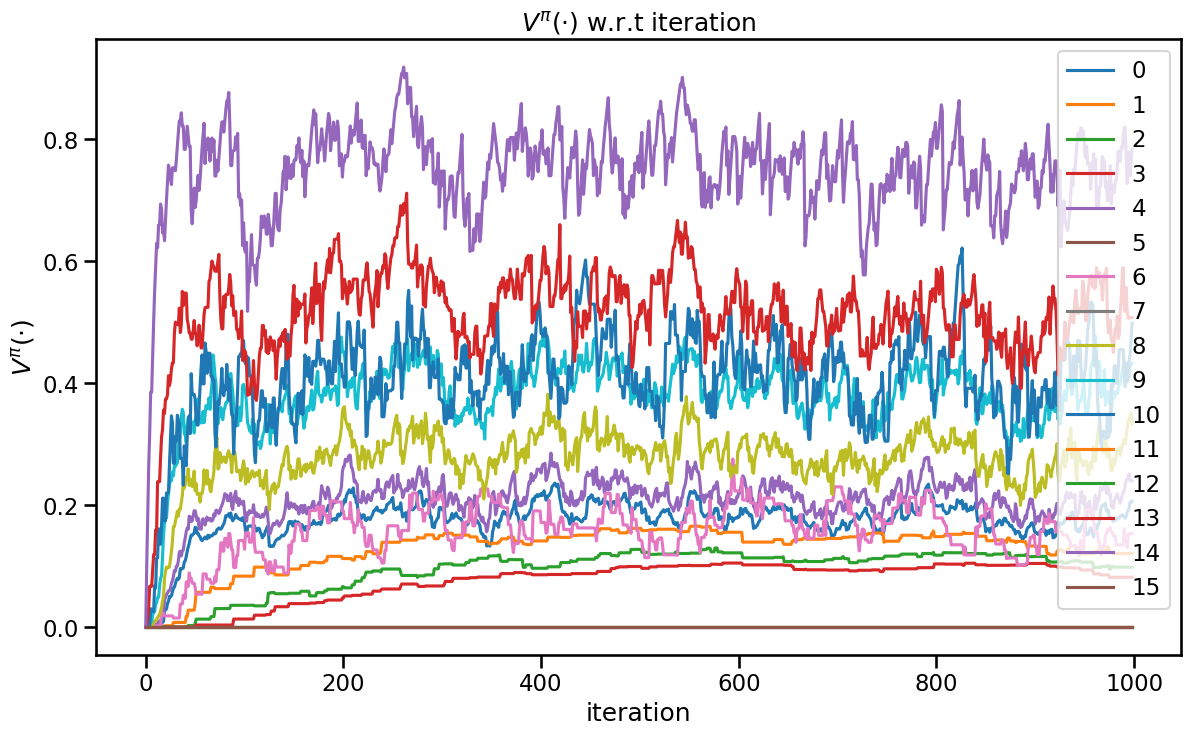

In [114]:
v_array_ex1, v_array_history_ex1, alpha_history_ex1 = td_learning(policy, environment, alpha=0.1, alpha_factor=1, display=False)

df_v_hist_ex1 = pd.DataFrame(v_array_history_ex1)
df_v_hist_ex1.plot(figsize=(14, 8))
plt.title(r"$V^{\pi}(\cdot)$ w.r.t iteration")
plt.ylabel(r"$V^{\pi}(\cdot)$")
plt.xlabel("iteration")
plt.legend(loc="upper right");

#### Bonus question

What do you observe when you change the `alpha_factor` ?
What is the role of this parameter ?

The learning rate `alpha` determines how much the value function is updated at each step:

- `alpha` high means the algorithm learns quickly but may overshoot.
- `alpha` low means the algorithm learns slowly but more stably.

Often, the learning rate is decayed over time by a factor `alpha_factor` to stabilize learning as the agent gains more experience:

- `alpha_factor` ~ 0.995 means the algorithm will progressively reduce its learning rate becoming more stable over time allowing the algorithm to correctly converge.
- `alpha_factor` ~ 0.900 means the algorithm will rapidly reduce its learning rate becoming stable to quickly reducing the ability of the algorithm to correctly converge.

`alpha_factor` determines how the Temporal Difference algorithm will converge over iterations by modifying it's learning rate `alpha`.

## Exercise 2: SARSA

### The Greedy and Epsilon Greedy policies

In exercise 1, **TD-Learning** has been used to **estimate the value function** for a **given policy**.  
In the following exercises, we will now explore how to **find the optimal** (or a nearly optimal) policy.  
To do that, we will use two algorithms (*SARSA* and *Q-Learning*) that estimate a *Q-table* instead of a *V-table*.  

This *Q-table* provides the expected **cumulative reward** when the agent takes a given action $\boldsymbol{a}$ from any state $\boldsymbol{s}$ and then follows a specified *behavior policy* to choose subsequent actions until a terminal state is reached. (This behavior policy may also serve as an *exploration policy* guiding action selection.)  

While exploring the environment, the agent **updates** its *Q-table* using a **rule derived from the Bellman equation** (i.e., an *update rule*).  

The purpose of this third exercise is to implement the *greedy* and the $\epsilon$-*greedy* policies that agents will used to explore the environment and update their QTable:

$\displaystyle \pi^{Q^{\pi}}(\boldsymbol{s}) := \text{greedy}(\boldsymbol{s}, Q^{\pi}) = \arg\max_{\boldsymbol{a} \in \mathcal{A}} Q^{\pi}(\boldsymbol{s}, \boldsymbol{a})$


$\pi^{Q^{\pi}}_{\epsilon}(\boldsymbol{s}) := \epsilon\text{-greedy}(\boldsymbol{s}, Q^{\pi}) = $
randomly choose between $\underbrace{\text{greedy}(\boldsymbol{s}, Q^{\pi})}_{\text{with probability } 1 - \epsilon}$
and $~~ \underbrace{\text{a random action}}_{\text{with probability } \epsilon}$    i.e. $\epsilon \in (0,1]$

### Task 1: Implement the Greedy and Epsilon Greedy policies

In [115]:
def greedy_policy(state: int, q_array: np.ndarray) -> int:
    """
    Determine the action that maximizes the Q-value for a given state.

    Parameters
    ----------
    state : int
        The current state.
    q_array : np.ndarray
        The Q-table.

    Returns
    -------
    int
        The action that maximizes the Q-value for the given state.
    """
    # TODO...

    action = np.argmax(q_array[state])

    return action


def epsilon_greedy_policy(state: int, q_array: np.ndarray, epsilon: float) -> int:
    """
    Determine the action to take based on an epsilon-greedy policy.

    Parameters
    ----------
    state : int
        The current state.
    q_array : np.ndarray
        The Q-table.
    epsilon : float
        The probability of choosing a random action.

    Returns
    -------
    int
        The action to take.
    """
    # TODO...

    if np.random.rand() < epsilon:
        action = np.random.randint(q_array.shape[1])
    else:
        action = np.argmax(q_array[state])

    return action

### The SARSA algorithm

To find the optimal policy (or a nearly optimal policy) for the FrozenLake-v1 problem, we will first use the SARSA algorithm.
It is based on the online update of the *QTable* for the current policy, defined as:
$$
Q(s, a) = \mathbb{E}^{\pi} \left[ \sum_{t=0}^{H} \gamma^t r_{t}(s_t, a_t) | s_t=s_0, a=a_0 \right] ,
$$
where $\gamma \in (0, 1]$ is the discount factor, and $H$ the horizon of the episode.

The SARSA algorithm updates a tabular estimate of the Q-function using the following update rule:
$$
Q(s, a) \leftarrow Q(s, a) +
\alpha
\left[
\underbrace{\overbrace{r + \gamma Q(s', a')}^{\text{Target}} - Q(s, a)}_{\text{TD error}}
\right] ,
$$
where $\alpha \in (0, 1]$ is the learning rate, and $r_t$ is the reward received by the agent at time step $t$.
Most of the time, the SARSA algorithm is implemented with an $\epsilon$-greedy exploration strategy.
This strategy consists in selecting the best action learned so far with probability $(1 - \epsilon)$ and to select a random
action with probability $\epsilon$.

---

***The SARSA algorithm***

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br><br>

Initialize arbitrarily $Q(\boldsymbol{s}, \boldsymbol{a}) ~~~ \forall \boldsymbol{s} \in \mathcal{S}, \boldsymbol{a} \in \mathcal{A}(\boldsymbol{s})$,<br>
except that $Q(\boldsymbol{s}_F, \cdot) = 0 ~~~ \forall \boldsymbol{s}_F \in \mathcal{S}^F$ (initialize finale states)<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\boldsymbol{s} \leftarrow \text{env.reset}() \quad\quad\quad\quad\quad\quad$ (initialize $s$)<br>
	$\quad$ $\boldsymbol{a} \leftarrow \epsilon\text{-greedy}(\boldsymbol{s}, Q)$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $r, \boldsymbol{s}' \leftarrow \text{env.step}(\boldsymbol{a}) \quad\quad\quad\quad$ (take action $a$, observe $r$ and $s'$)<br>
		$\quad\quad$ $\boldsymbol{a}' \leftarrow \epsilon\text{-greedy}(\boldsymbol{s}', Q)$<br>
		$\quad\quad$ $Q(\boldsymbol{s},\boldsymbol{a}) \leftarrow Q(\boldsymbol{s},\boldsymbol{a}) + \alpha \left[ \underbrace{\overbrace{r + \gamma Q(s', a')}^{\text{Target}} ~ - ~ Q(\boldsymbol{s},\boldsymbol{a})}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $\boldsymbol{s} \leftarrow \boldsymbol{s}'$<br>
		$\quad\quad$ $\boldsymbol{a} \leftarrow \boldsymbol{a}'$<br>
	$\quad$ <b>UNTIL</b> $\boldsymbol{s}$ is final

### Task 2: Implement the SARSA algorithm

**Tasks**: Implement the SARSA algorithm with $\epsilon$-greedy exploration (start with $\epsilon = 0.5$).

In [116]:
DISPLAY_EVERY_N_EPISODES = 50

def sarsa(
    environment: gym.Env,
    alpha: float = 0.1,
    alpha_factor: float = 0.9995,
    gamma: float = 0.99,
    epsilon: float = 0.5,
    num_episodes: int = 10000,
    display: bool = False,
) -> Tuple[np.ndarray, List[np.ndarray], List[float]]:
    """
    Perform SARSA learning on a given environment.

    Parameters
    ----------
    environment : gym.Env
        The environment to learn in.
    alpha : float, optional
        The learning rate, between 0 and 1. By default 0.1
    alpha_factor : float, optional
        The factor to decrease alpha by each episode, by default 0.9995
    gamma : float, optional
        The discount factor, between 0 and 1. By default 0.99
    epsilon : float, optional
        The probability of choosing a random action, by default 0.5
    num_episodes : int, optional
        The number of episodes to run, by default 10000
    display : bool, optional
        Whether to display the Q-table (every DISPLAY_EVERY_N_EPISODES episodes), by default False

    Returns
    -------
    np.ndarray
        The learned Q-table.
        Each row corresponds to a state, and each column corresponds to an action.
        In the frozen lake environment, there are 16 states and 4 actions thus the Q-table has a shape of (16, 4).
        For instance, q_array[0, 3] is the Q-value (estimation of the expected reward) for performing action 3 ("move up") in state 0 (the top left square).
    """
    # Initialize the history of the Q-table and learning rate
    q_array_history = []
    alpha_history = []

    observation_space = cast(gym.spaces.Discrete, environment.observation_space)
    action_space = cast(gym.spaces.Discrete, environment.action_space)

    # Get the number of states in the environment
    num_states = observation_space.n

    # Get the number of actions in the environment
    num_actions = action_space.n

    # Initialize the Q-table to zeros
    q_array = np.zeros([num_states, num_actions])

    # Loop over the episodes
    for episode_index in tqdm(range(1, num_episodes)):
        # Display the Q-table every DISPLAY_EVERY_N_EPISODES episodes if display is True
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            display_qtable(q_array, title="Q table")

        # Save the current Q-table and learning rate
        q_array_history.append(q_array.copy())
        alpha_history.append(alpha)

        # Decrease the learning rate if alpha_factor is not None
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        # TODO...
        state, _ = environment.reset()
        action = epsilon_greedy_policy(state, q_array, epsilon)

        done = False
        while not done:
            # Take the action and observe the next state and reward
            next_state, reward, done, _, _ = environment.step(action)
            next_action = epsilon_greedy_policy(next_state, q_array, epsilon)

            # Update the value function using the TD learning update rule
            td_error = reward + gamma * q_array[next_state, next_action] - q_array[state, action]
            q_array[state, action] += alpha * td_error

            # Move to the next state
            state = next_state
            action = next_action

    # Return the learned Q-table
    return q_array, q_array_history, alpha_history

**Note**: In the following cell, the `display` argument can be set to `True` to see the evolution of the action-value function `q_array` over iterations.

In [117]:
# Create the environment and set the maximum number of steps per episode
environment = gym.make("FrozenLake-v1", max_episode_steps=1000)

# Apply SARSA to calculate the Q-table for the FrozenLake environment
q_array_ex2, q_array_history_ex2, alpha_history_ex2 = sarsa(environment, display=False)

environment.close()

  0%|          | 0/9999 [00:00<?, ?it/s]

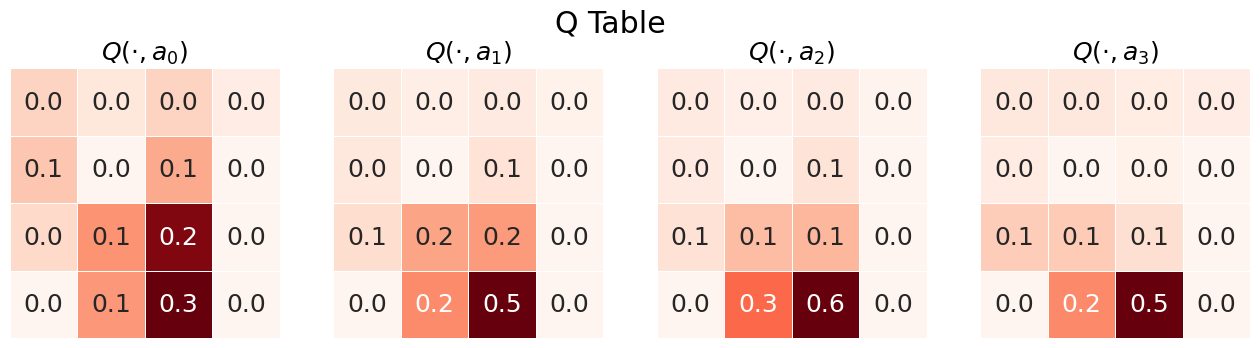

In [118]:
# Display the learned Q-table
display_qtable(q_array_ex2, title="Q Table")

#### Question 2

Copy and paste the output of the following cell into the second question of the [Lab 5 - Evaluation](https://moodle.polytechnique.fr/course/section.php?id=66533) in Moodle:  
*"What is the Q-value Q(s0,a0) of the initial state and action 0 ("Move Left") in the FrozenLake environment using the default parameters?"*

In [119]:
e2q2_answer = q_array_ex2[0][0].item()
print(f"{e2q2_answer:.2f}")

0.04


### Display the greedy policy

In [120]:
policy_ex2 = [greedy_policy(state, q_array_ex2) for state in range(environment.observation_space.n)]
policy_ex2

[np.int64(0),
 np.int64(3),
 np.int64(0),
 np.int64(3),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(3),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(0)]

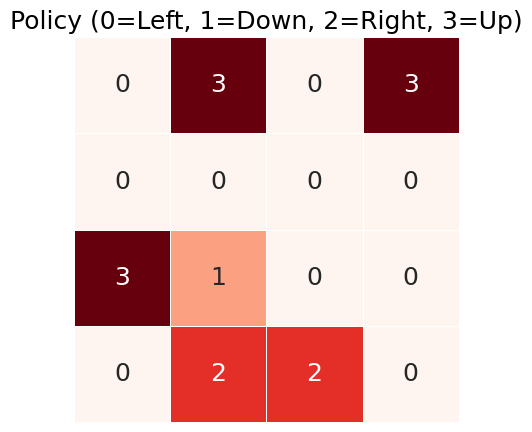

In [121]:
display_policy(policy_ex2, environment)

### Display the evolution of the value function over iterations

In [122]:
# Make a Pandas dataframe containing the evolution of the Q-table during the learning process
q_array_history_array_ex2 = np.array(q_array_history_ex2)
df_q_hist_list_ex2 = []

for action_index in range(q_array_history_array_ex2.shape[2]):
    df_q_hist_list_ex2.append(pd.DataFrame(q_array_history_array_ex2[:, :, action_index]))

Evolution of `q_array_ex2` over iterations (one curve per state):

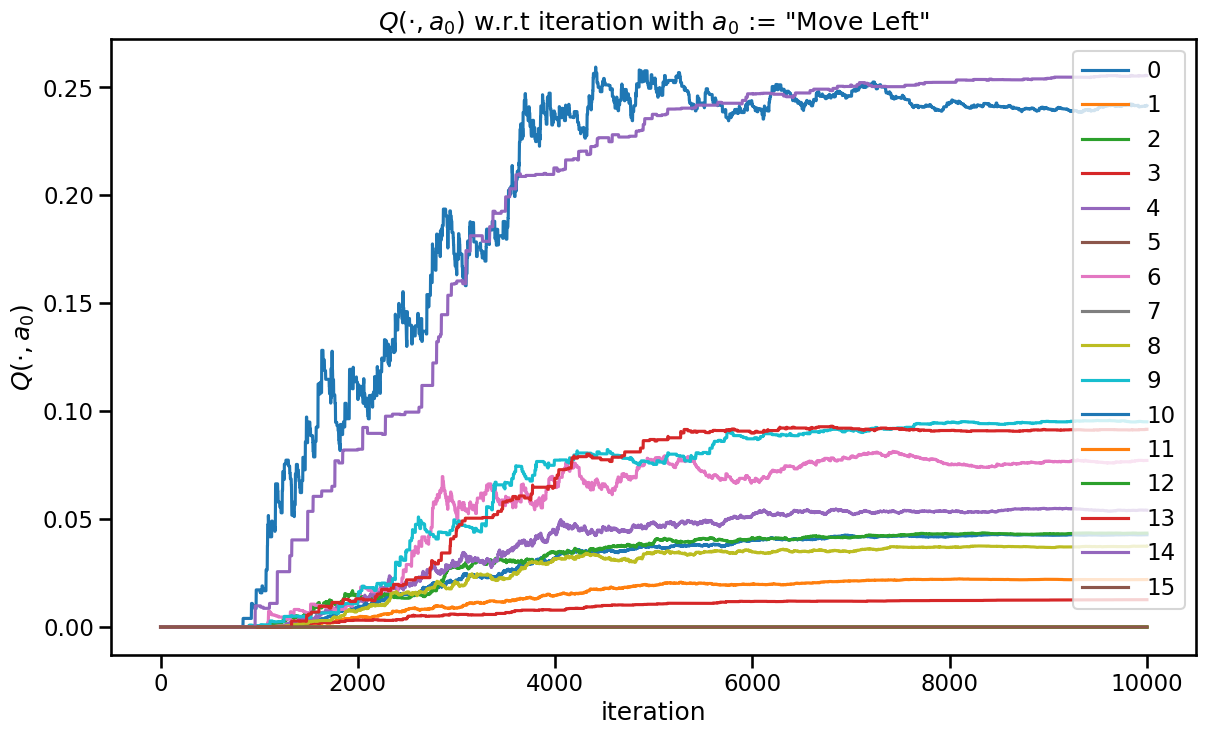

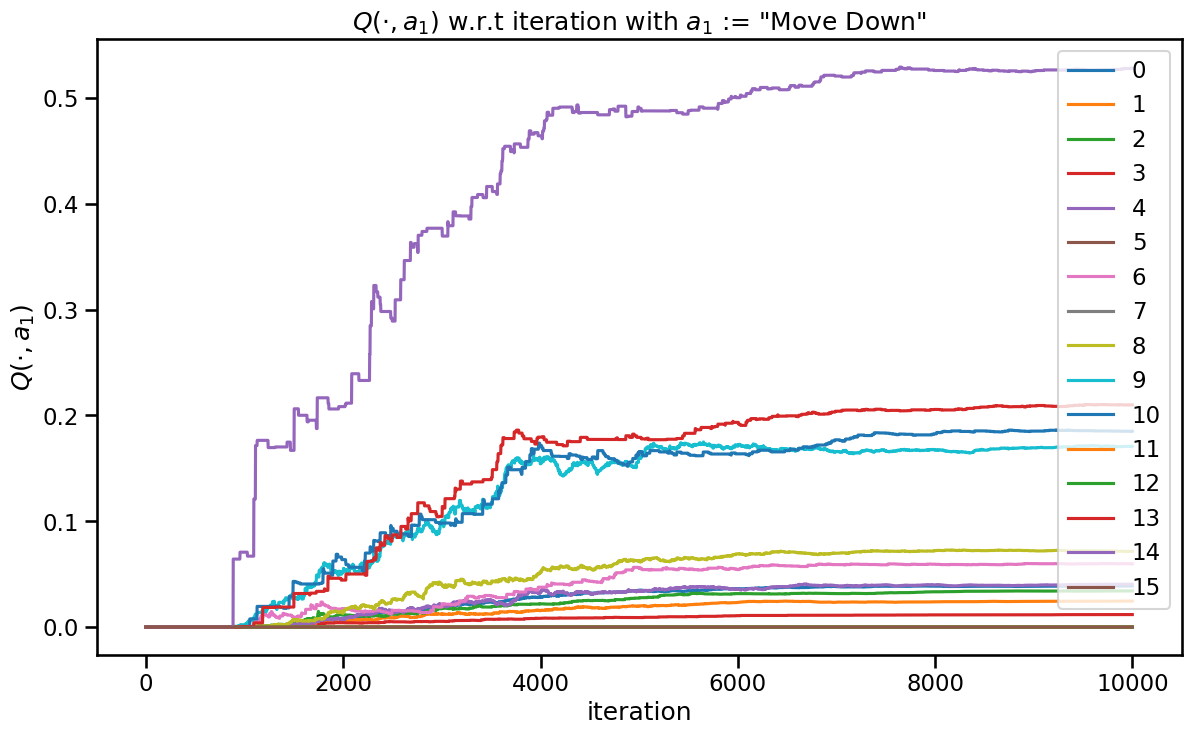

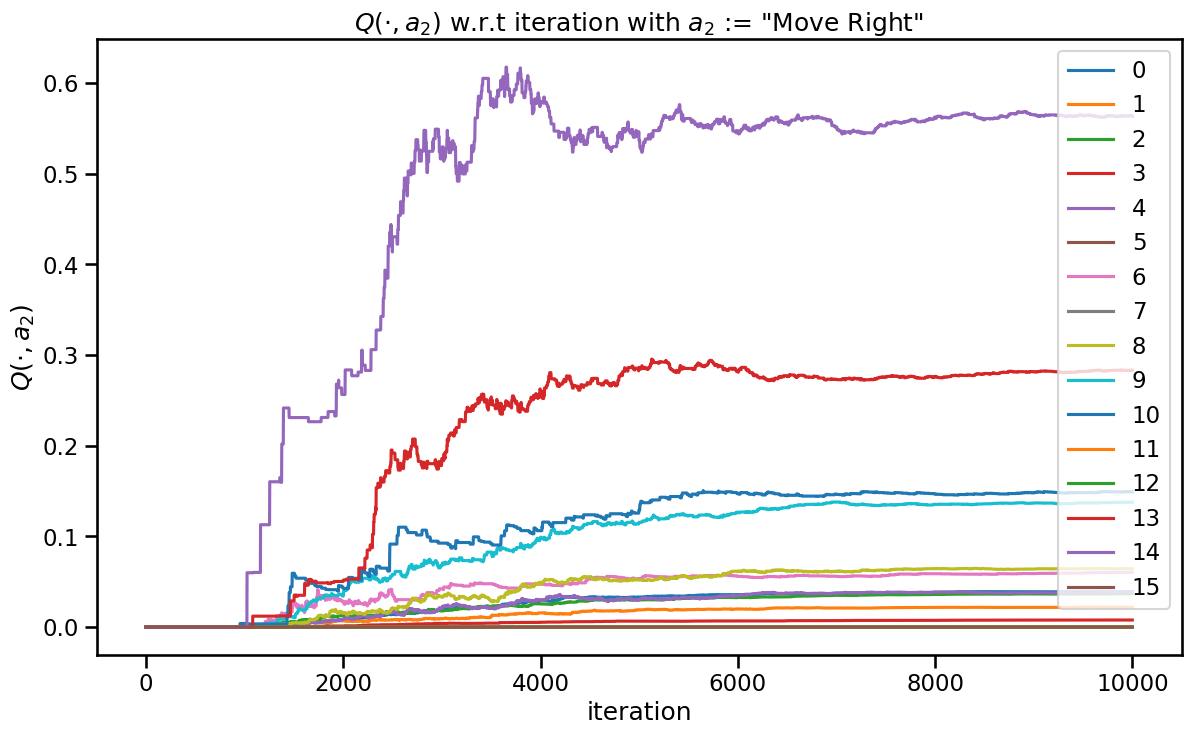

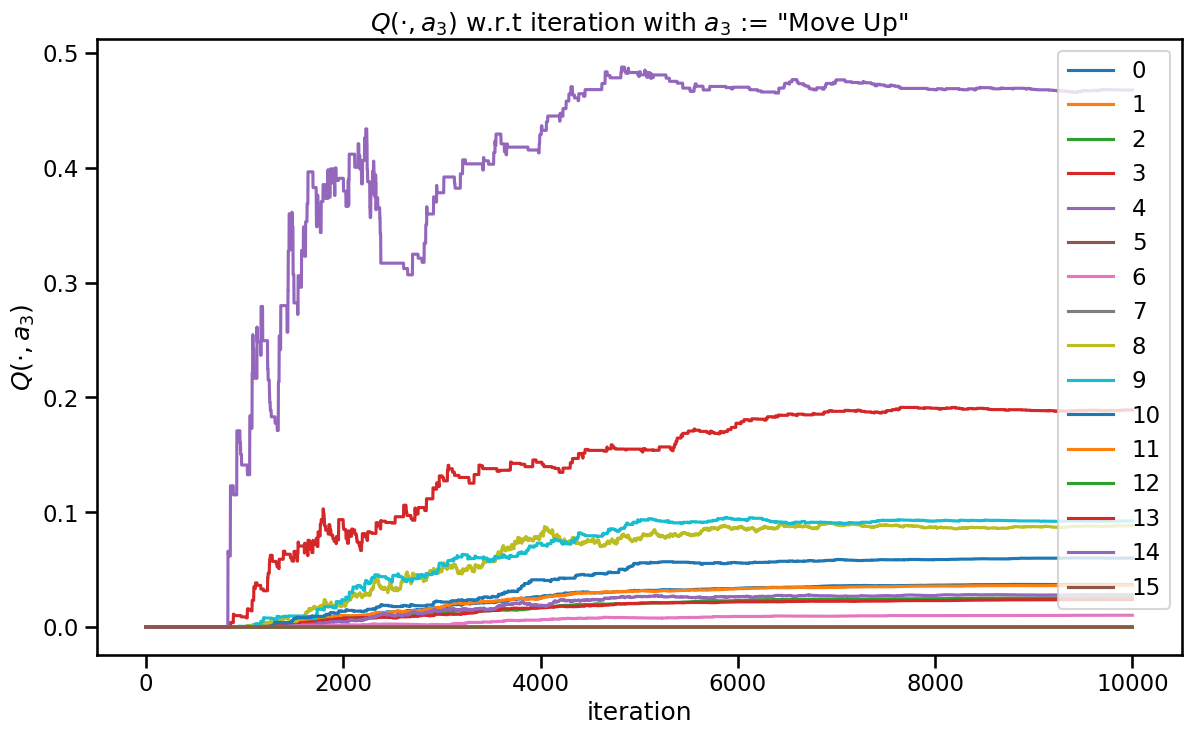

In [123]:
# Show the evolution of the estimated expected value for each action and state during the learning process
for action_index, df_q_hist in enumerate(df_q_hist_list_ex2):
    df_q_hist.plot(figsize=(14,8))
    plt.title(r'$Q(\cdot,a_{})$ w.r.t iteration with $a_{}$ := "{}"'.format(action_index, action_index, action_labels[action_index]))
    plt.ylabel(r"$Q(\cdot,a_{})$".format(action_index))
    plt.xlabel("iteration")
    plt.legend(loc="upper right")

Text(0.5, 0, 'iteration')

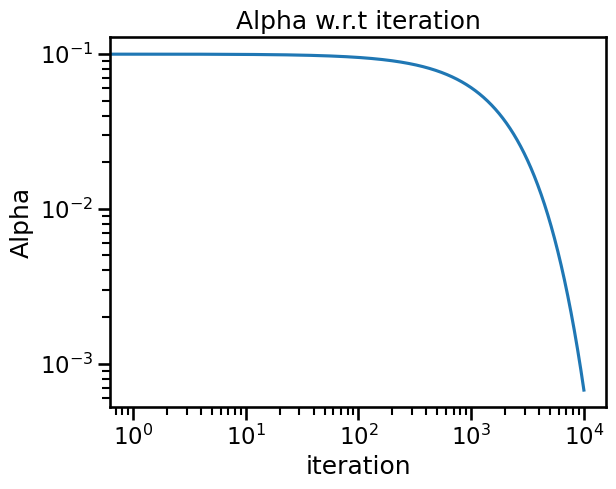

In [124]:
# Show the evolution of the alpha parameter during the learning process
plt.loglog(alpha_history_ex2)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration")

### Evaluate Policy with Gymnasium

As a measure of performance, count the number of successful trials on 1000 episodes.

**Note**: Gymnasium considers the task is solved if you reach 76\% of success over the episodes.

In [125]:
environment = gym.make("FrozenLake-v1", max_episode_steps=1000)

reward_list = []
NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state, info = environment.reset()
    episode_over = False

    while not episode_over:
        # action = epsilon_greedy_policy(state, q_array_ex2, epsilon)
        action = greedy_policy(state, q_array_ex2)
        state, reward, terminated, truncated, info = environment.step(action)
        episode_over = terminated or truncated

    reward_list.append(reward)

reward_df = pd.DataFrame(reward_list)

print('Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1):', np.average(reward_df))

environment.close()

Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1): 0.675


### Test the optimized policy

In [126]:
NUM_EPISODES = 3

FIGS_DIR = Path("figs/")       # Where to save figures (.gif files)

VIDEO_DIRNAME_EX2 = "lab5_ex2_sarsa"

(FIGS_DIR / VIDEO_DIRNAME_EX2 / "rl-video-episode-0.mp4").unlink(missing_ok=True)
(FIGS_DIR / VIDEO_DIRNAME_EX2 / "rl-video-episode-1.mp4").unlink(missing_ok=True)
(FIGS_DIR / VIDEO_DIRNAME_EX2 / "rl-video-episode-2.mp4").unlink(missing_ok=True)

environment = gym.make("FrozenLake-v1", max_episode_steps=1000, render_mode="rgb_array")
environment = gym.wrappers.RecordVideo(environment, video_folder=FIGS_DIR / VIDEO_DIRNAME_EX2, episode_trigger=lambda x: True)
environment = gym.wrappers.RecordEpisodeStatistics(environment, buffer_length=NUM_EPISODES)

for episode_index in range(NUM_EPISODES):
    state, info = environment.reset()

    episode_over = False
    while not episode_over:
        # action = epsilon_greedy_policy(state, q_array_ex2, epsilon)
        action = greedy_policy(state, q_array_ex2)
        state, reward, terminated, truncated, info = environment.step(action)
        episode_over = terminated or truncated

    reward_list.append(reward)

print(f'Episode time taken: {environment.time_queue}')
print(f'Episode total rewards: {environment.return_queue}')
print(f'Episode lengths: {environment.length_queue}')

environment.close()

/home/trofino/.local/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/trofino/git_repositories/classes_ensta/3A/CSC_52081_EP/CSC_52081_EP_TP5/figs/lab5_ex2_sarsa folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode time taken: deque([0.018109, 0.006279, 0.115204], maxlen=3)
Episode total rewards: deque([1.0, 1.0, 1.0], maxlen=3)
Episode lengths: deque([35, 14, 178], maxlen=3)


In [127]:
Video(FIGS_DIR / VIDEO_DIRNAME_EX2 / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

In [128]:
Video(FIGS_DIR / VIDEO_DIRNAME_EX2 / "rl-video-episode-1.mp4", embed=True, html_attributes="controls autoplay loop")

In [129]:
Video(FIGS_DIR / VIDEO_DIRNAME_EX2 / "rl-video-episode-2.mp4", embed=True, html_attributes="controls autoplay loop")

## Exercise 3: QLearning

Another reinforcement learning algorithm is *Q-Learning*.
The fundamental difference from *SARSA* is that it is an *off-policy* algorithm.
This means it learns from trajectories generated by a policy different from the one it is optimizing.
In other words, the *behavior policy* (*epsilon-greedy*) is different from the *target policy* (*greedy*).

To do so, it uses the following update rule:
$$
Q(s, a) \leftarrow Q(s, a) +
\alpha
\left[
\underbrace{\overbrace{r + \gamma \max_{a^* \in \mathcal{A}} Q(s', a^*)}^{\text{Target}} - Q(s, a)}_{\text{TD error}}
\right] ,
$$

**Task**: in this exercise, you will replace the SARSA update rule by the Q-learning one and analyze the
differences in performances.

---

### The QLearning algorithm

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br><br>

Initialize arbitrarily $Q(\boldsymbol{s}, \boldsymbol{a}) ~~~ \forall \boldsymbol{s} \in \mathcal{S}, \boldsymbol{a} \in \mathcal{A}(\boldsymbol{s})$,<br>
except that $Q(\boldsymbol{s}_F, \cdot) = 0 ~~~ \forall \boldsymbol{s}_F \in \mathcal{S}^F$ (initialize finale states)<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\boldsymbol{s} \leftarrow \text{env.reset}() \quad\quad\quad\quad\quad\quad$ (initialize $s$)<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\boldsymbol{a} \leftarrow \epsilon\text{-greedy}(\boldsymbol{s}, Q)$<br>
		$\quad\quad$ $r, \boldsymbol{s}' \leftarrow \text{env.step}(\boldsymbol{a}) \quad\quad\quad\quad$ (take action $a$, observe $r$ and $s'$)<br>
		$\quad\quad$ $Q(\boldsymbol{s},\boldsymbol{a}) \leftarrow Q(\boldsymbol{s},\boldsymbol{a}) + \alpha \left[ \underbrace{\overbrace{r + \gamma ~ \max_{\boldsymbol{a^*} \in \mathcal{A}} Q(\boldsymbol{s}', \boldsymbol{a^*})}^{\text{Target}} ~ - ~ Q(\boldsymbol{s},\boldsymbol{a})}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $\boldsymbol{s} \leftarrow \boldsymbol{s}'$<br>
	$\quad$ <b>UNTIL</b> $\boldsymbol{s}$ is final

### Task 1: Implement the QLearning algorithm

In [130]:
DISPLAY_EVERY_N_EPISODES = 50

def q_learning(
    environment: gym.Env,
    alpha: float = 0.1,
    alpha_factor: float = 0.9995,
    gamma: float = 0.99,
    epsilon: float = 0.5,
    num_episodes: int = 10000,
    display: bool = False,
) -> Tuple[np.ndarray, List[np.ndarray], List[float]]:
    """
    Perform Q-learning on a given environment.

    Parameters
    ----------
    environment : gym.Env
        The environment to learn in.
    alpha : float, optional
        The learning rate, between 0 and 1. By default 0.1
    alpha_factor : float, optional
        The factor to decrease alpha by each episode, by default 0.9995
    gamma : float, optional
        The discount factor, between 0 and 1. By default 0.99
    epsilon : float, optional
        The probability of choosing a random action, by default 0.5
    num_episodes : int, optional
        The number of episodes to run, by default 10000
    display : bool, optional
        Whether to display the Q-table (every DISPLAY_EVERY_N_EPISODES episodes), by default False

    Returns
    -------
    np.ndarray
        The learned Q-table.
        Each row corresponds to a state, and each column corresponds to an action.
        In the frozen lake environment, there are 16 states and 4 actions thus the Q-table has a shape of (16, 4).
        For instance, q_array[0, 3] is the Q-value (estimation of the expected reward) for performing action 3 ("move up") in state 0 (the top left square).
    """
    # Initialize the history of the Q-table and learning rate
    q_array_history = []
    alpha_history = []

    observation_space = cast(gym.spaces.Discrete, environment.observation_space)
    action_space = cast(gym.spaces.Discrete, environment.action_space)

    # Get the number of states in the environment
    num_states = observation_space.n

    # Get the number of actions in the environment
    num_actions = action_space.n

    # Initialize the Q-table to zeros
    q_array = np.zeros([num_states, num_actions])

    # Loop over the episodes
    for episode_index in tqdm(range(1, num_episodes)):
        # Display the Q-table every DISPLAY_EVERY_N_EPISODES episodes if display is True
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            display_qtable(q_array, title="Q table")

        # Save the current Q-table and learning rate
        q_array_history.append(q_array.copy())
        alpha_history.append(alpha)

        # Decrease the learning rate if alpha_factor is not None
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        # TODO...
        state, _ = environment.reset()

        done = False
        while not done:
            action = epsilon_greedy_policy(state, q_array, epsilon)
            # Take the action and observe the next state and reward
            next_state, reward, done, _, _ = environment.step(action)

            # Update the value function using the TD learning update rule
            td_error = reward + gamma * np.max(q_array[next_state]) - q_array[state, action]
            q_array[state, action] += alpha * td_error

            # Move to the next state
            state = next_state

    # Return the learned Q-table
    return q_array, q_array_history, alpha_history

**Note**: In the following cell, the `display` argument can be set to `True` to see the evolution of the action-value function `q_array` over iterations.

In [131]:
# Create the environment and set the maximum number of steps per episode
environment = gym.make("FrozenLake-v1", max_episode_steps=1000)

# Apply Q-learning to calculate the Q-table for the FrozenLake environment
q_array_ex3, q_array_history_ex3, alpha_history_ex3 = q_learning(environment, display=False)

environment.close()

  0%|          | 0/9999 [00:00<?, ?it/s]

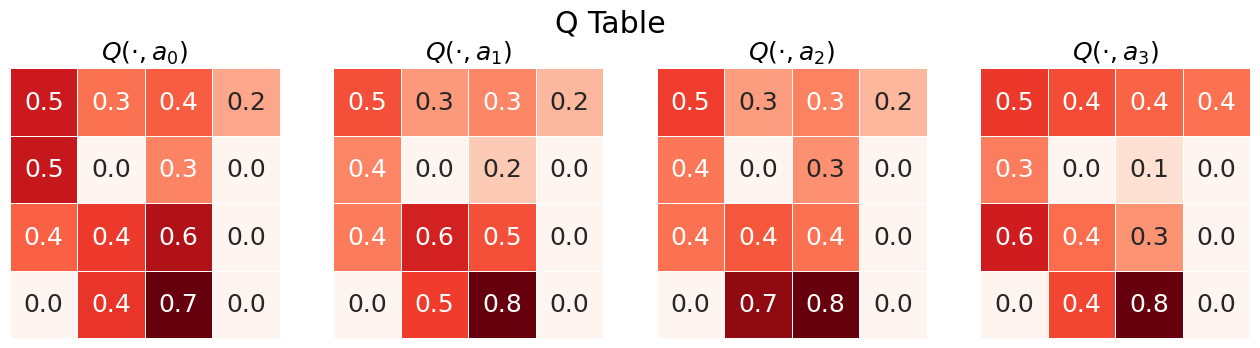

In [ ]:

# Display the learned Q-table
display_qtable(q_array_ex3, title="Q Table")
action_labels

#### Question 3

Copy and paste the output of the following cell into the third question of the [Lab 5 - Evaluation](https://moodle.polytechnique.fr/course/section.php?id=66533) in Moodle:  
*"What is the Q-value Q(s0,a0) of the initial state and action 0 ("Move Left") in the FrozenLake environment using the default parameters?"*

In [133]:
e3q3_answer = q_array_ex3[0][0].item()
print(f"{e3q3_answer:.2f}")

0.51


### Display the greedy policy

In [134]:
policy_ex3 = [greedy_policy(state, q_array_ex3) for state in range(environment.observation_space.n)]
policy_ex3

[np.int64(0),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(3),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(1),
 np.int64(0)]

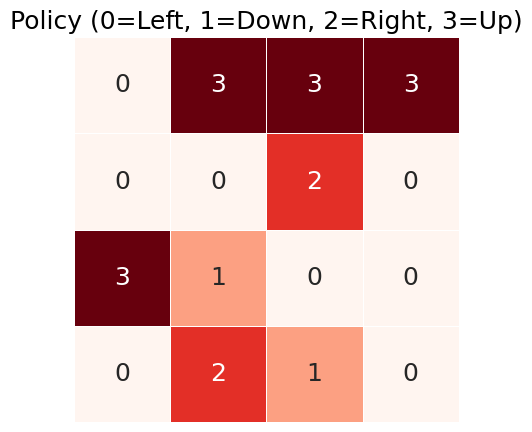

In [135]:
display_policy(policy_ex3, environment)

### Display the evolution of the value function over iterations

In [136]:
# Make a Pandas dataframe containing the evolution of the Q-table during the learning process
q_array_history_array_ex3 = np.array(q_array_history_ex3)
df_q_hist_list_ex3 = []

for action_index in range(q_array_history_array_ex3.shape[2]):
    df_q_hist_list_ex3.append(pd.DataFrame(q_array_history_array_ex3[:, :, action_index]))

Evolution of `q_array_ex3` over iterations (one curve per state):

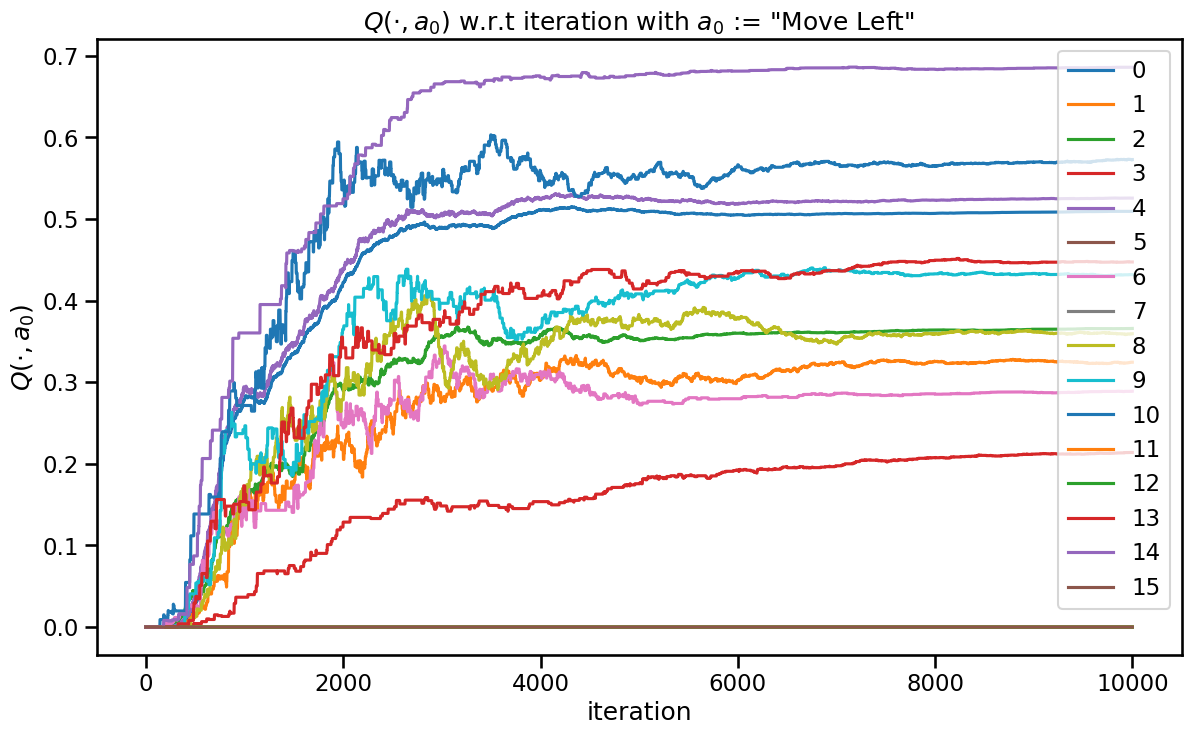

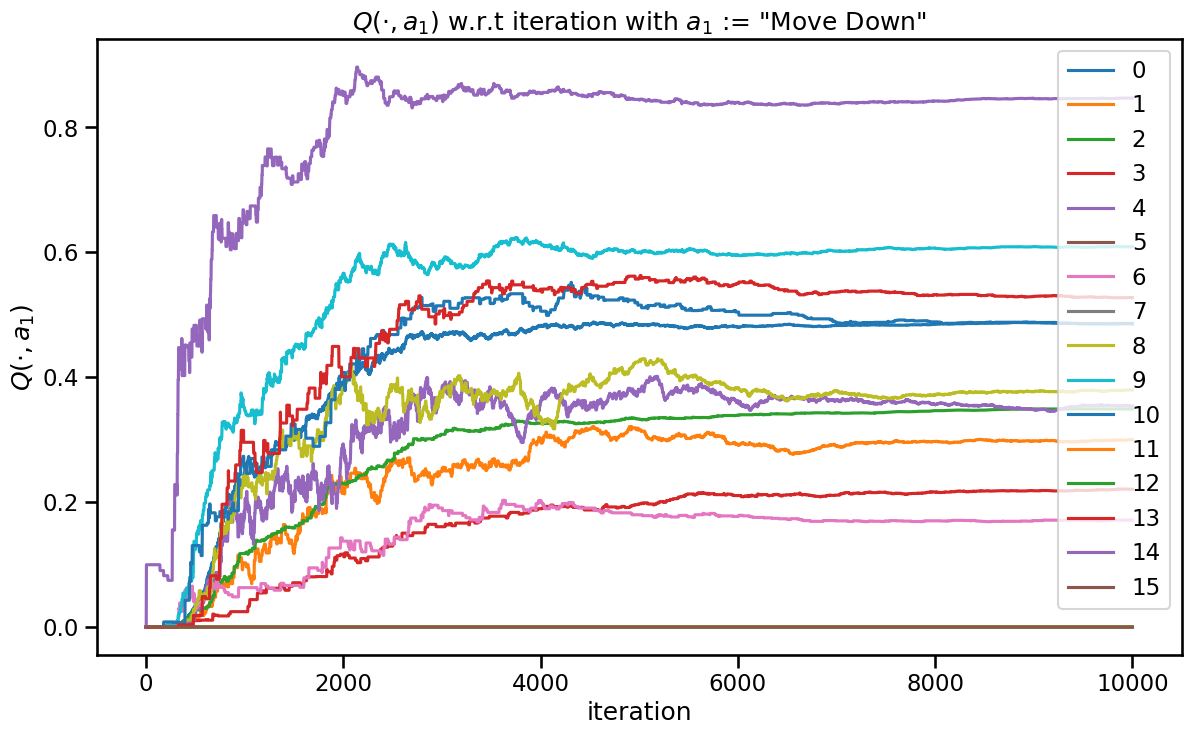

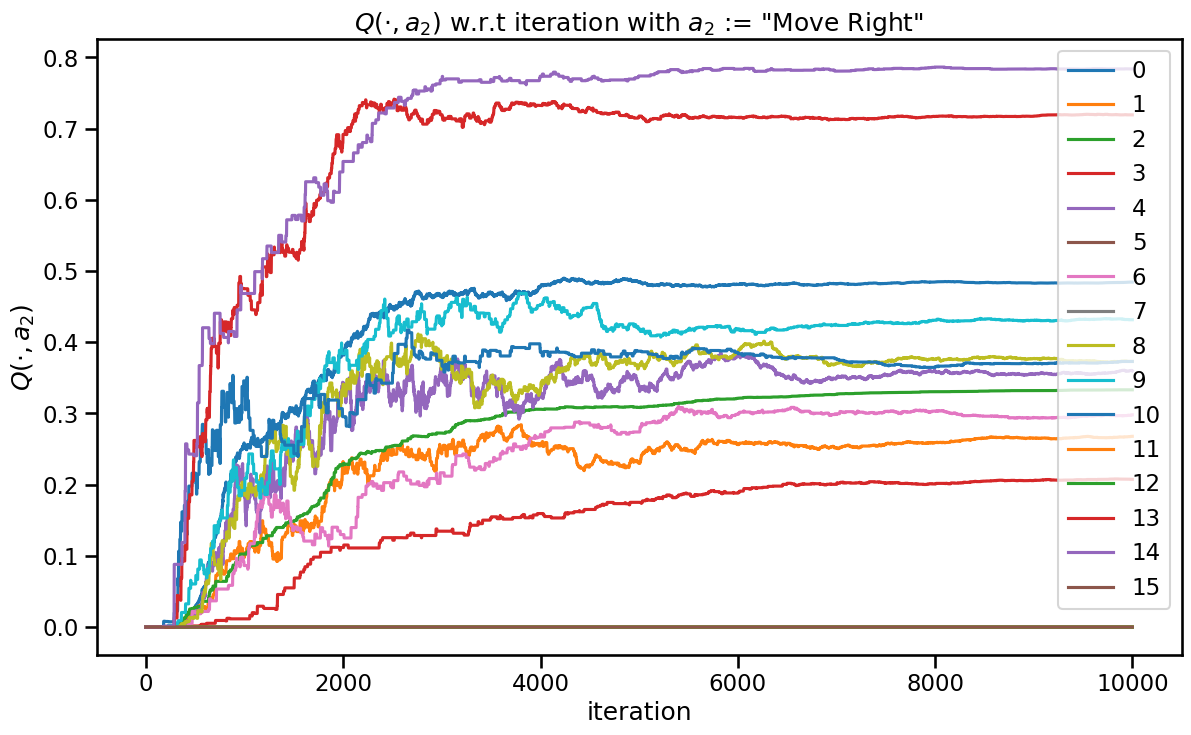

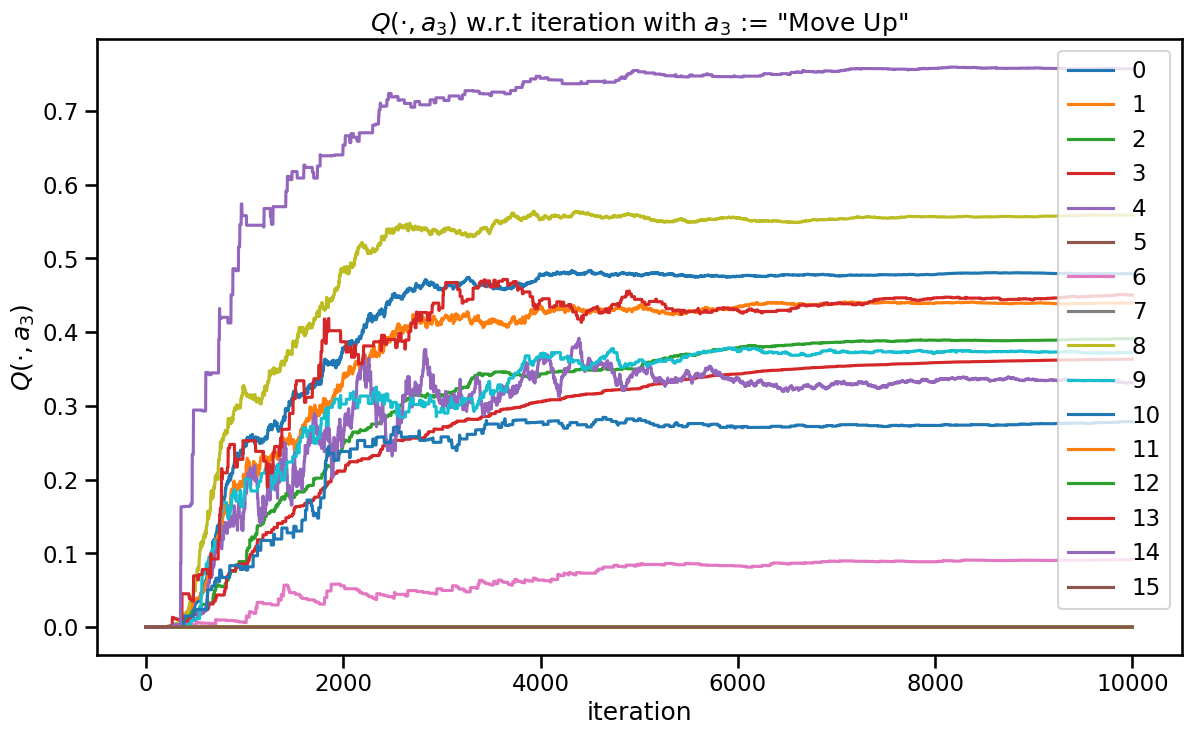

In [137]:
# Show the evolution of the estimated expected value for each action and state during the learning process
for action_index, df_q_hist in enumerate(df_q_hist_list_ex3):
    df_q_hist.plot(figsize=(14,8))
    plt.title(r'$Q(\cdot,a_{})$ w.r.t iteration with $a_{}$ := "{}"'.format(action_index, action_index, action_labels[action_index]))
    plt.ylabel(r"$Q(\cdot,a_{})$".format(action_index))
    plt.xlabel("iteration")
    plt.legend(loc="upper right")

Text(0.5, 0, 'iteration')

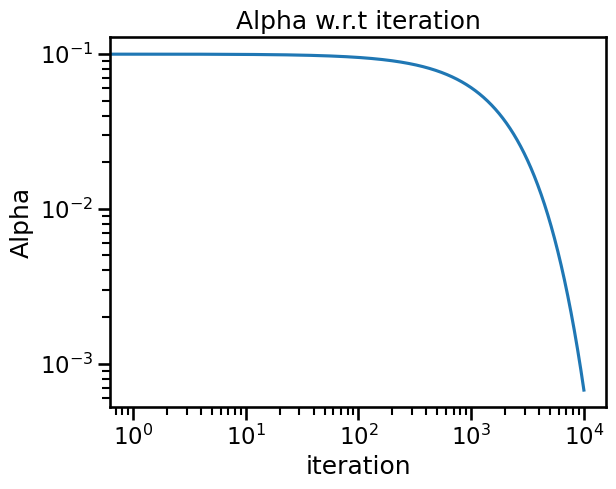

In [138]:
# Show the evolution of the alpha parameter during the learning process
plt.loglog(alpha_history_ex3)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration")

### Evaluate Policy with Gymnasium

As a measure of performance, count the number of successful trials on 1000 episodes.

**Note**: Gymnasium considers the task is solved if you reach 76\% of success over the episodes.

In [139]:
environment = gym.make("FrozenLake-v1", max_episode_steps=1000)

reward_list = []
NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state, info = environment.reset()
    episode_over = False

    while not episode_over:
        # action = epsilon_greedy_policy(state, q_array_ex3, epsilon)
        action = greedy_policy(state, q_array_ex3)
        state, reward, terminated, truncated, info = environment.step(action)
        episode_over = terminated or truncated

    reward_list.append(reward)

reward_df = pd.DataFrame(reward_list)

print(
    'Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1):',
    np.average(reward_df),
)

environment.close()

### Test the optimized policy

In [ ]:
NUM_EPISODES = 3

FIGS_DIR = Path("figs/")       # Where to save figures (.gif files)

VIDEO_DIRNAME_EX3 = "lab5_ex3_qlearning"

(FIGS_DIR / VIDEO_DIRNAME_EX3 / "rl-video-episode-0.mp4").unlink(missing_ok=True)
(FIGS_DIR / VIDEO_DIRNAME_EX3 / "rl-video-episode-1.mp4").unlink(missing_ok=True)
(FIGS_DIR / VIDEO_DIRNAME_EX3 / "rl-video-episode-2.mp4").unlink(missing_ok=True)

environment = gym.make("FrozenLake-v1", max_episode_steps=1000, render_mode="rgb_array")
environment = gym.wrappers.RecordVideo(environment, video_folder=FIGS_DIR / VIDEO_DIRNAME_EX3, episode_trigger=lambda x: True)
environment = gym.wrappers.RecordEpisodeStatistics(environment, buffer_length=NUM_EPISODES)

for episode_index in range(NUM_EPISODES):
    state, info = environment.reset()

    episode_over = False
    while not episode_over:
        # action = epsilon_greedy_policy(state, q_array_ex3, epsilon)
        action = greedy_policy(state, q_array_ex3)
        state, reward, terminated, truncated, info = environment.step(action)
        episode_over = terminated or truncated

    reward_list.append(reward)

print(f'Episode time taken: {environment.time_queue}')
print(f'Episode total rewards: {environment.return_queue}')
print(f'Episode lengths: {environment.length_queue}')

environment.close()

/home/trofino/.local/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/trofino/git_repositories/classes_ensta/3A/CSC_52081_EP/CSC_52081_EP_TP5/figs/lab5_ex3_qlearning folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode time taken: deque([0.049337, 0.020271, 0.038541], maxlen=3)
Episode total rewards: deque([1.0, 1.0, 1.0], maxlen=3)
Episode lengths: deque([94, 39, 38], maxlen=3)


In [ ]:
Video(FIGS_DIR / VIDEO_DIRNAME_EX3 / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

In [ ]:
Video(FIGS_DIR / VIDEO_DIRNAME_EX3 / "rl-video-episode-1.mp4", embed=True, html_attributes="controls autoplay loop")

In [ ]:
Video(FIGS_DIR / VIDEO_DIRNAME_EX3 / "rl-video-episode-2.mp4", embed=True, html_attributes="controls autoplay loop")